# Wikipedia whole graph visualization

In [23]:
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
from operator import itemgetter
import graphviz

In [24]:
DATA_PATH = Path.cwd() / "data/wikispeedia_paths-and-graph/"
raw_graph = (DATA_PATH / "shortest-path-distance-matrix.txt").resolve()
raw_graph


WindowsPath('C:/Users/Cyril/Desktop/Code/ada-2023-project-adamants/data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt')

In [25]:
assert raw_graph.is_file()

In [26]:
data = np.loadtxt(raw_graph, dtype=str)

In [27]:
def convert_to_matrix(data):
    """Replaces each row (string) with the integer values of the string and replaces _ with NaN"""
    data = np.array([[int(i) if i != "_" else np.nan for i in row] for row in data])
    return data

In [28]:
graph = convert_to_matrix(data)
graph.shape

(4604, 4604)

In [29]:
# sns.heatmap(graph)
# plt.show()

In [30]:
if scp.linalg.issymmetric(graph):
    print("Undirected graph")
else:
    print("Directed graph")


Directed graph


In [31]:
adjacency_matrix = np.where(graph == 1, 1, 0)
adjacency_matrix = np.where(np.isnan(adjacency_matrix), 0, adjacency_matrix) # remove nan

degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
# sort matrix by degree
adjacency_matrix = adjacency_matrix[np.argsort(np.sum(adjacency_matrix, axis=1))]

nx_graph = nx.from_numpy_array(adjacency_matrix.astype(int), create_using=nx.DiGraph) # maybe pickle this for later use
print(nx_graph)


DiGraph with 4604 nodes and 119772 edges


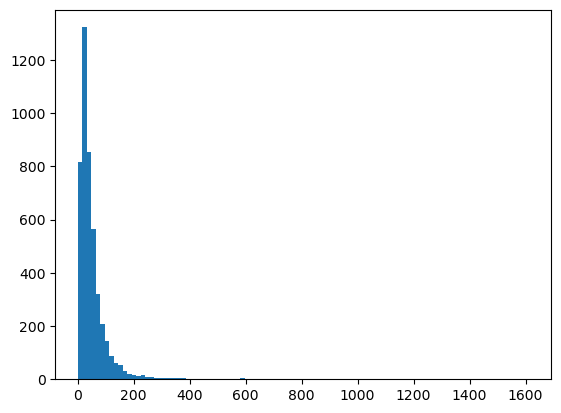

In [32]:
# make a histogram of the degree distribution
degree_sequence = sorted([d for n, d in nx_graph.degree()], reverse=True)
plt.hist(degree_sequence, bins=100)
plt.show()

In [33]:
# pickle nx_graph
# import pickle
# with open(DATA_PATH / "nx_graph.pickle", "wb") as f:
#     pickle.dump(nx_graph, f)

In [34]:
# load pickle if needed
if nx_graph is None:
    import pickle
    with open(DATA_PATH / "nx_graph.pickle", "rb") as f:
        nx_graph = pickle.load(f)

In [35]:
USE_SUBGRAPH = True # reduce number of nodes for performance
N = 1000  # number of node to keep for the visualization

if USE_SUBGRAPH:
    # nodelist = np.random.permutation(nx_graph.nodes())[:N]
    # subgraph = nx_graph.subgraph(nodelist).copy()
    # keep only nodes with degree > 100
    subgraph = nx_graph.copy()
    subgraph.remove_nodes_from(list(nx.isolates(subgraph)))
    subgraph.remove_nodes_from([n for n, d in subgraph.degree() if d < 100])
else:
    subgraph = nx_graph.copy()

In [36]:
print(subgraph)

DiGraph with 486 nodes and 13370 edges


In [37]:
subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  # remove self-loops for visualization
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))  # remove isolated nodes for visualization
print(subgraph)

DiGraph with 486 nodes and 13352 edges


In [43]:
plt.figure(figsize=(10, 10), dpi=1000)
# color nodes according to their degree
degrees = subgraph.degree() #Dict with Node ID, Degree
nodes = subgraph.nodes()
n_color = np.asarray([degrees[n] for n in nodes])
# pos = nx.kamada_kawai_layout(subgraph)
pos = nx.spring_layout(subgraph, iterations=20, k=0.1)
nx.draw(subgraph, pos, node_size=5, width=0.1, alpha=0.5, arrows=False, node_color=n_color, cmap="viridis")
plt.show()
# plt.savefig("graph.svg")

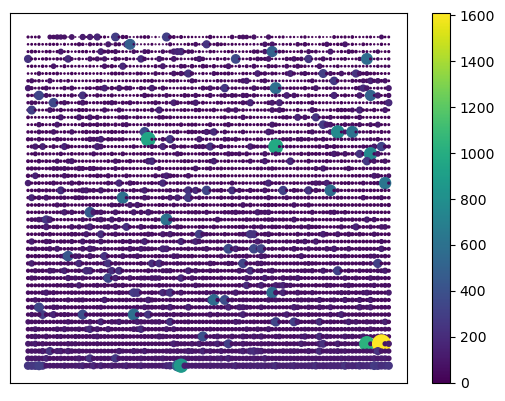

In [39]:
ncols = 100
n = len(nx_graph.nodes())
pos = {i : (i % ncols, (n-i-1)//ncols) for i in nx_graph.nodes()}

fig, ax = plt.subplots()
degrees = nx_graph.degree() #Dict with Node ID, Degree
nodes = nx_graph.nodes()
n_color = np.asarray([degrees[n] for n in nodes])
sc = nx.draw_networkx_nodes(nx_graph, pos, nodelist=nodes, node_color=n_color, cmap='viridis',
                            ax=ax, node_size=n_color/10)
# use a log-norm, do not see how to pass this through nx API
# just set it after-the-fact
# sc.set_norm(nx_graph.LogNorm(vmin=1, vmax=1000))
fig.colorbar(sc)
plt.show()

In [40]:
# fancy viz, but takes a long time and DOES NOT WORK IN VISUAL STUDIO
# if you do get it to work in VSC, please let me know how :)

# g=Network(notebook=True, cdn_resources="in_line")
# g.from_nx(nx.convert_node_labels_to_integers(subgraph))
# g.show_buttons(filter_=['physics'])
# # g.show("nx.html")
# html = g.generate_html()
# with open("graph_viz.html", mode='w', encoding='utf-8') as fp:
#         fp.write(html)

In [41]:
# display(HTML(html)) # USE IN YOUR BROWSER through jupyter lab or notebook
# OR you can open the html file in your browser